In [1]:
import os
os.chdir('../')

In [10]:
import torch

pt_file = 'outputs/sd-v1-4/uni_pc_steps200_scale1.0/50.pt'
data = torch.load(pt_file)
print(data.keys())
print(data['text'])

dict_keys(['latent', 'image', 'text'])
['A boy flying a kite in a park.', 'A Giraffe stooping over in an open field.', 'Children scale and stand on a fence overlooking an arched entrance. ']


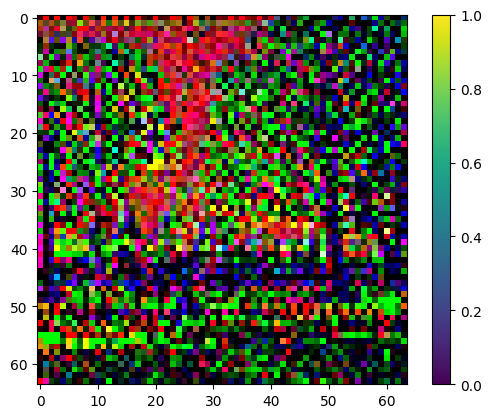

In [11]:
import matplotlib.pyplot as plt

plt.imshow(data['image'][0][:3].permute(1, 2, 0))
plt.colorbar()
plt.show()

In [ ]:
# 0) 필요한 라이브러리 import
import numpy as np
import torch
from omegaconf import OmegaConf
from ldm.util import instantiate_from_config
from einops import rearrange
from PIL import Image

# 1) 모델 및 VAE 로드 함수 정의
def load_model_from_config(config_path, ckpt_path):
    """
    config_path: 모델 설정 파일 경로
    ckpt_path: .ckpt 모델 파일 경로
    """
    # 설정 파일 로드
    config = OmegaConf.load(config_path)
    
    # checkpoint(.ckpt) 불러오기
    print(f"Loading model from {ckpt_path}")
    pl_sd = torch.load(ckpt_path, map_location="cpu", weights_only=False)
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")

    # state_dict를 이용해 모델 초기화
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    missing, unexpected = model.load_state_dict(sd, strict=False)

    # 모델을 GPU로 옮기고, eval 모드
    model.cuda()
    model.eval()

    # 로드 과정에서 누락되었거나 예기치 못한 키 정보 확인
    if missing:
        print("Missing keys:", missing)
    if unexpected:
        print("Unexpected keys:", unexpected)

    return model

# 2) config와 checkpoint 경로 지정
config_path = "configs/stable-diffusion/v1-inference.yaml"
ckpt_path   = "models/ldm/stable-diffusion-v1/sd-v1-4.ckpt"

# 3) 모델 로드
model = load_model_from_config(config_path, ckpt_path)

# 4) First Stage Model(VAE)만 추출
vae = model.first_stage_model


Loading model from models/ldm/stable-diffusion-v1/sd-v1-4.ckpt


/home/logpx/miniconda3/envs/rbf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-11 15:39:39.115975: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-11 15:39:39.135013: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-11 15:39:39.135038: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-11 15:39:39

Global Step: 470000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Unexpected keys: ['model_ema.decay', 'model_ema.num_updates', 'cond_stage_model.transformer.text_model.embeddings.position_ids']
done


In [12]:
# 5) VAE 예시 사용: 랜덤 latent → 이미지 디코딩
#    (512x512 기준, latent 크기는 (1,4,64,64))
with torch.no_grad():
    random_latent = data['image'].cuda()
    x_samples = model.decode_first_stage(random_latent)
    x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)
    x_samples = x_samples.cpu().permute(0, 2, 3, 1).numpy()
    x_image_torch = torch.from_numpy(x_samples).permute(0, 3, 1, 2)

    images = []
    for x_sample in x_image_torch:
        x_sample = 255.0 * rearrange(x_sample.cpu().numpy(), "c h w -> h w c")
        img = Image.fromarray(x_sample.astype(np.uint8))
        images.append(img)
print('done')

done


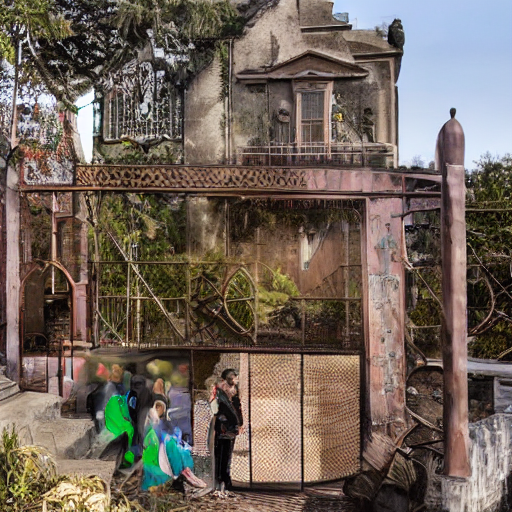

In [15]:
images[2]